In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

In [5]:
import pickle

with open('database.pkl', 'rb') as f:
    data_PKL = pickle.load(f)
    
data_PKL.head()

,Symbol,Contract,Date,Time,Open,High,Low,Close,Volume
0,TX,201801,2018-01-02,08:45:00,10629,10632,10621,10627,1556
1,TX,201801,2018-01-02,08:45:05,10627,10629,10624,10624,228
2,TX,201801,2018-01-02,08:45:10,10624,10627,10624,10627,170
3,TX,201801,2018-01-02,08:45:15,10628,10631,10627,10630,386
4,TX,201801,2018-01-02,08:45:20,10630,10630,10627,10628,118


In [2]:
data = pd.read_pickle('database.pkl')
data.head()

,Symbol,Contract,Date,Time,Open,High,Low,Close,Volume
0,TX,201801,2018-01-02,08:45:00,10629,10632,10621,10627,1556
1,TX,201801,2018-01-02,08:45:05,10627,10629,10624,10624,228
2,TX,201801,2018-01-02,08:45:10,10624,10627,10624,10627,170
3,TX,201801,2018-01-02,08:45:15,10628,10631,10627,10630,386
4,TX,201801,2018-01-02,08:45:20,10630,10630,10627,10628,118


In [14]:
data.shape

(406800, 9)

In [3]:
signal = np.load('trading_signal.npy')
signal.shape

(270000, 1)

In [10]:
# 原本是在-6到6間
signal[30:]

array([[ 0],
       [-1],
       [ 0],
       ...,
       [ 0],
       [ 0],
       [ 0]])

In [4]:
# 調成0以上
signal = signal + 6
close = data['Close'].values

### 正規化

In [5]:
close = (close - np.mean(close)) / np.std(close)

### 存sequence

In [6]:
signal_matrix = np.zeros((406770, 30))
# 計算收盤價差值
for i in range(406770):
    signal_matrix[i, :] = close[i+1:i+31] - close[i:i+30]

### 切Train, Test

In [7]:
x_train = signal_matrix[:269971, :]
x_test = signal_matrix[269971:, :]

In [16]:
x_train.shape

(269971, 30)

### DNN

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten

model_DNN = Sequential()
model_DNN.add(Dense(128, input_shape=(30, ), activation = 'relu'))
model_DNN.add(Dense(64, activation = 'relu'))
model_DNN.add(Dense(40, activation = 'relu'))
model_DNN.add(Dense(32, activation = 'relu'))
model_DNN.add(Dense(32, activation = 'relu'))
model_DNN.add(Dense(20, activation = 'relu'))
model_DNN.add(Dense(10, activation = 'relu'))
model_DNN.add(Dense(13, activation='softmax'))

model_DNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_DNN.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
__________

In [9]:
train_history_DNN = model_DNN.fit(x=x_train, y=signal[29:], validation_split=0.2, epochs=50, batch_size=300, verbose=2)

Train on 215976 samples, validate on 53995 samples
Epoch 1/100
 - 5s - loss: 1.0462 - acc: 0.7052 - val_loss: 0.9583 - val_acc: 0.7094
Epoch 2/100
 - 2s - loss: 0.9187 - acc: 0.7076 - val_loss: 0.8431 - val_acc: 0.7163
Epoch 3/100
 - 2s - loss: 0.7590 - acc: 0.7265 - val_loss: 0.7046 - val_acc: 0.7360
Epoch 4/100
 - 2s - loss: 0.6914 - acc: 0.7404 - val_loss: 0.6590 - val_acc: 0.7481
Epoch 5/100
 - 2s - loss: 0.6604 - acc: 0.7462 - val_loss: 0.6452 - val_acc: 0.7485
Epoch 6/100
 - 2s - loss: 0.6302 - acc: 0.7554 - val_loss: 0.6380 - val_acc: 0.7549
Epoch 7/100
 - 2s - loss: 0.5974 - acc: 0.7709 - val_loss: 0.5572 - val_acc: 0.7888
Epoch 8/100
 - 2s - loss: 0.5659 - acc: 0.7881 - val_loss: 0.5479 - val_acc: 0.7994
Epoch 9/100
 - 2s - loss: 0.5420 - acc: 0.7995 - val_loss: 0.5418 - val_acc: 0.8000
Epoch 10/100
 - 2s - loss: 0.5233 - acc: 0.8073 - val_loss: 0.5127 - val_acc: 0.8139
Epoch 11/100
 - 2s - loss: 0.5116 - acc: 0.8124 - val_loss: 0.4867 - val_acc: 0.8234
Epoch 12/100
 - 2s - lo

In [10]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

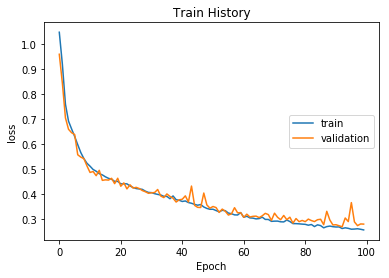

In [11]:
show_train_history(train_history_DNN, 'loss', 'val_loss')

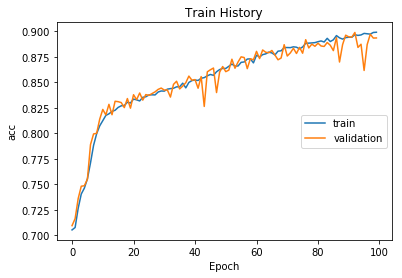

In [12]:
show_train_history(train_history_DNN, 'acc', 'val_acc')

In [21]:
prediction_DNN = model_DNN.predict(x_test)
prediction_DNN[0]

array([1.01136902e-05, 1.55886846e-05, 1.77182752e-04, 1.41592452e-03,
       1.91352535e-02, 1.21079564e-01, 6.73671186e-01, 1.53746799e-01,
       1.94518976e-02, 1.11795524e-02, 8.18517365e-05, 2.24310133e-05,
       1.26439090e-05], dtype=float32)

In [23]:
prediction_DNN_class = model_DNN.predict_classes(x_test)
prediction_DNN_class[0]

6

### CNN

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

model_CNN = Sequential()
model_CNN.add(Conv1D(128, kernel_size=5,
                 activation='relu',
                 input_shape=(30, 1,)))
model_CNN.add(Conv1D(64, 5, activation='relu'))
# model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Conv1D(32, 3, activation='relu'))
# model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Dropout(0.25))
model_CNN.add(Flatten())

model_CNN.add(Dense(128, activation='relu'))
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(13, activation='softmax'))

model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 26, 128)           768       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 64)            41024     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 20, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               41088     
__________

In [14]:
# extend dimension
xtrain_1d = np.expand_dims(x_train, 2)
xtrain_1d.shape

(269971, 30, 1)

In [19]:
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history_CNN = model_CNN.fit(x=xtrain_1d, y=signal[29:], validation_split=0.2, epochs=50, batch_size=500, verbose=2)

Train on 215976 samples, validate on 53995 samples
Epoch 1/50
 - 3s - loss: 1.1036 - acc: 0.7036 - val_loss: 0.9605 - val_acc: 0.7094
Epoch 2/50
 - 3s - loss: 1.0036 - acc: 0.7067 - val_loss: 0.9604 - val_acc: 0.7094
Epoch 3/50
 - 3s - loss: 0.9685 - acc: 0.7065 - val_loss: 0.7657 - val_acc: 0.7104
Epoch 4/50
 - 3s - loss: 0.7679 - acc: 0.7183 - val_loss: 0.6809 - val_acc: 0.7406
Epoch 5/50
 - 3s - loss: 0.6979 - acc: 0.7367 - val_loss: 0.6054 - val_acc: 0.7677
Epoch 6/50
 - 3s - loss: 0.6592 - acc: 0.7516 - val_loss: 0.5714 - val_acc: 0.7829
Epoch 7/50
 - 3s - loss: 0.6328 - acc: 0.7633 - val_loss: 0.5474 - val_acc: 0.7904
Epoch 8/50
 - 3s - loss: 0.6094 - acc: 0.7716 - val_loss: 0.5387 - val_acc: 0.7955
Epoch 9/50
 - 3s - loss: 0.5926 - acc: 0.7778 - val_loss: 0.5091 - val_acc: 0.8042
Epoch 10/50
 - 3s - loss: 0.5813 - acc: 0.7814 - val_loss: 0.4997 - val_acc: 0.8084
Epoch 11/50
 - 3s - loss: 0.5749 - acc: 0.7847 - val_loss: 0.4889 - val_acc: 0.8112
Epoch 12/50
 - 3s - loss: 0.5588 -

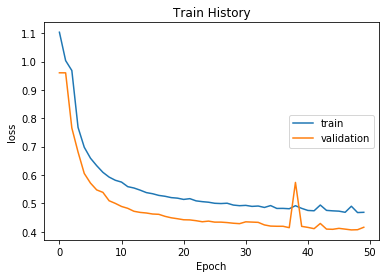

In [20]:
show_train_history(train_history_CNN, 'loss', 'val_loss')

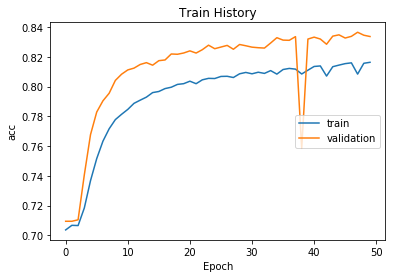

In [21]:
show_train_history(train_history_CNN, 'acc', 'val_acc')

### RNN

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, CuDNNLSTM

model_LSTM2 = Sequential()

model_LSTM2.add(LSTM(64, input_shape=(30, 1), return_sequences=True))
model_LSTM2.add(LSTM(32, return_sequences=False))

model_LSTM2.add(Dense(13, activation='softmax'))

model_LSTM2.summary()

model_LSTM2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                429       
Total params: 29,741
Trainable params: 29,741
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_history_LSTM2 = model_LSTM2.fit(x=xtrain_1d, y=signal[29:], batch_size=1000, epochs=50, verbose=2, validation_split=0.2)

Train on 215976 samples, validate on 53995 samples
Epoch 1/50
 - 17s - loss: 1.1091 - acc: 0.6989 - val_loss: 0.9628 - val_acc: 0.7094
Epoch 2/50
 - 15s - loss: 0.9731 - acc: 0.7067 - val_loss: 0.9612 - val_acc: 0.7094
Epoch 3/50
 - 15s - loss: 0.9721 - acc: 0.7067 - val_loss: 0.9594 - val_acc: 0.7094
Epoch 4/50
 - 15s - loss: 0.9660 - acc: 0.7067 - val_loss: 0.9370 - val_acc: 0.7094
Epoch 5/50
 - 16s - loss: 0.8890 - acc: 0.7069 - val_loss: 0.8051 - val_acc: 0.7109
Epoch 6/50
 - 16s - loss: 0.7706 - acc: 0.7129 - val_loss: 0.7276 - val_acc: 0.7218
Epoch 7/50
 - 16s - loss: 0.7232 - acc: 0.7213 - val_loss: 0.6883 - val_acc: 0.7295
Epoch 8/50
 - 16s - loss: 0.6964 - acc: 0.7296 - val_loss: 0.6699 - val_acc: 0.7353
Epoch 9/50
 - 16s - loss: 0.6732 - acc: 0.7364 - val_loss: 0.6544 - val_acc: 0.7448
Epoch 10/50
 - 16s - loss: 0.6571 - acc: 0.7422 - val_loss: 0.6439 - val_acc: 0.7494
Epoch 11/50
 - 16s - loss: 0.6422 - acc: 0.7471 - val_loss: 0.6194 - val_acc: 0.7545
Epoch 12/50
 - 16s - lo

* Overfitting if: training loss << validation loss

* Underfitting if: training loss >> validation loss

* Just right if training loss ~ validation loss

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, CuDNNLSTM

model_LSTM3 = Sequential()

model_LSTM3.add(CuDNNLSTM(64, input_shape=(30, 1), return_sequences=True))
model_LSTM3.add(CuDNNLSTM(32, return_sequences=False))

model_LSTM3.add(Dense(40, activation='relu'))
model_LSTM3.add(Dense(13, activation='softmax'))

model_LSTM3.summary()

model_LSTM3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 30, 64)            17152     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1320      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                533       
Total params: 31,549
Trainable params: 31,549
Non-trainable params: 0
_________________________________________________________________


In [10]:
train_history_LSTM3 = model_LSTM3.fit(x=xtrain_1d, y=signal[29:], batch_size=300, epochs=100, verbose=2, validation_split=0.2)

Train on 215976 samples, validate on 53995 samples
Epoch 1/100
 - 7s - loss: 1.0042 - acc: 0.7035 - val_loss: 0.8716 - val_acc: 0.7094
Epoch 2/100
 - 4s - loss: 0.7673 - acc: 0.7148 - val_loss: 0.6919 - val_acc: 0.7273
Epoch 3/100
 - 4s - loss: 0.6823 - acc: 0.7333 - val_loss: 0.6371 - val_acc: 0.7470
Epoch 4/100
 - 4s - loss: 0.6396 - acc: 0.7466 - val_loss: 0.6004 - val_acc: 0.7611
Epoch 5/100
 - 4s - loss: 0.6083 - acc: 0.7573 - val_loss: 0.5930 - val_acc: 0.7641
Epoch 6/100
 - 4s - loss: 0.5872 - acc: 0.7645 - val_loss: 0.5661 - val_acc: 0.7708
Epoch 7/100
 - 4s - loss: 0.5725 - acc: 0.7685 - val_loss: 0.5508 - val_acc: 0.7793
Epoch 8/100
 - 4s - loss: 0.5591 - acc: 0.7723 - val_loss: 0.5452 - val_acc: 0.7768
Epoch 9/100
 - 4s - loss: 0.5482 - acc: 0.7755 - val_loss: 0.5244 - val_acc: 0.7839
Epoch 10/100
 - 4s - loss: 0.5360 - acc: 0.7791 - val_loss: 0.5249 - val_acc: 0.7846
Epoch 11/100
 - 4s - loss: 0.5275 - acc: 0.7828 - val_loss: 0.5001 - val_acc: 0.7944
Epoch 12/100
 - 4s - lo

### CNN_LSTM

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional, CuDNNLSTM
model_Hybiard = Sequential()
model_Hybiard.add(Conv1D(128, kernel_size=5,
                 activation='relu',
                 input_shape=(30, 1,)))
model_Hybiard.add(Conv1D(64, 5, activation='relu'))
model_Hybiard.add(MaxPooling1D(pool_size=2))

model_Hybiard.add(CuDNNLSTM(64, return_sequences=True))
model_Hybiard.add(CuDNNLSTM(32, return_sequences=False))
model_Hybiard.add(Dropout(0.25))

model_Hybiard.add(Dense(64, activation='relu'))
model_Hybiard.add(Dense(32, activation='relu'))
model_Hybiard.add(Dense(13, activation='softmax'))

model_Hybiard.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 26, 128)           768       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 22, 64)            41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 11, 64)            33280     
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
__________

In [13]:
model_Hybiard.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history_Hybiard = model_Hybiard.fit(x=xtrain_1d, y=signal, batch_size=500, epochs=100, verbose=2, validation_split=0.2)

Train on 215976 samples, validate on 53994 samples
Epoch 1/100
 - 4s - loss: 0.3508 - acc: 0.8549 - val_loss: 0.3557 - val_acc: 0.8552
Epoch 2/100
 - 4s - loss: 0.3497 - acc: 0.8556 - val_loss: 0.3485 - val_acc: 0.8546
Epoch 3/100
 - 4s - loss: 0.3440 - acc: 0.8572 - val_loss: 0.3514 - val_acc: 0.8542
Epoch 4/100
 - 4s - loss: 0.3430 - acc: 0.8581 - val_loss: 0.3569 - val_acc: 0.8498
Epoch 5/100
 - 4s - loss: 0.3428 - acc: 0.8578 - val_loss: 0.3528 - val_acc: 0.8579
Epoch 6/100
 - 4s - loss: 0.3436 - acc: 0.8578 - val_loss: 0.3657 - val_acc: 0.8484
Epoch 7/100
 - 4s - loss: 0.3384 - acc: 0.8597 - val_loss: 0.3402 - val_acc: 0.8593
Epoch 8/100
 - 4s - loss: 0.3368 - acc: 0.8613 - val_loss: 0.3463 - val_acc: 0.8551
Epoch 9/100
 - 4s - loss: 0.3362 - acc: 0.8602 - val_loss: 0.3402 - val_acc: 0.8592
Epoch 10/100
 - 4s - loss: 0.3353 - acc: 0.8618 - val_loss: 0.3431 - val_acc: 0.8577
Epoch 11/100
 - 4s - loss: 0.3328 - acc: 0.8621 - val_loss: 0.3378 - val_acc: 0.8602
Epoch 12/100
 - 4s - lo